In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


#np.set_printoptions(threshold=np.inf)

# Load the dataset

In [17]:
df = pd.read_csv('CryptoDatasetReddit.csv',index_col=0)

In [19]:
df.columns

Index(['open_BTCUSDT', 'high_BTCUSDT', 'low_BTCUSDT', 'close_BTCUSDT',
       'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD',
       'volume_ETHUSD', 'reddit_flair', 'reddit_tb_polarity',
       'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg',
       'reddit_sid_neu', 'reddit_sid_com'],
      dtype='object')

In [21]:
df

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg
timestamp,,,,,,,,,,,,,,
2018-01-01 00:00:00,13820.26,13820.26,13498.05,13557.88,210.213142,222.24,590.23000,728.77,625.293831,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-01 01:00:00,13557.88,13585.66,13250.50,13262.85,191.931776,215.20,698.36000,724.27,710.891607,-0.267228,0.046199,0.257910,0.105625,0.091875
2018-01-01 02:00:00,13262.85,13400.00,13186.02,13320.00,169.456410,215.36,464.55000,722.11,849.257651,-0.300781,-0.077217,0.273153,0.032000,0.019333
2018-01-01 03:00:00,13320.00,13515.44,13308.54,13372.00,80.455327,219.30,407.81000,733.19,556.397003,0.082537,0.242468,0.404416,0.156286,0.025000
2018-01-01 04:00:00,13372.00,13499.83,13279.50,13483.06,127.212610,223.72,965.39000,738.59,1247.722800,0.443654,0.235317,0.321429,0.153143,0.005143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-20 19:00:00,8099.26,8109.92,8077.82,8086.65,1.910237,54.68,26.89869,174.40,22.319940,0.328284,0.142630,0.506278,0.110429,0.049857
2019-11-20 20:00:00,8083.19,8111.17,8081.72,8102.66,9.783435,55.06,21.18500,174.45,25.050680,0.000208,0.375000,0.500000,0.314500,0.000000
2019-11-20 21:00:00,8096.06,8111.25,8078.80,8098.29,1.726209,55.10,16.47622,175.48,32.281160,0.187590,-0.077778,0.144444,0.000000,0.157500


# Dataset scalling

In [22]:
dataset = df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(df.columns)
print('Number of features', num_of_features)

Number of features 14


# Model Config

In [1]:
look_back = 30*24 # 60 days, as each entry is for 1 hour
lstm_layers = 42
epochs=10
batch_size=128

# Spliting datasets into train and test

In [60]:
trainSize = 0.70
predictCol = df.columns.get_loc('close_BTCUSDT')

def create_dataset(dataset, predictCol, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, predictCol])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * trainSize)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, predictCol, look_back=look_back)
testX, testY = create_dataset(test, predictCol, look_back=look_back)

trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look back ', look_back)

Training dataset length  11575
Testing dataset length  4961
look_back  720


# Building model and train

In [1]:
model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-9e317912da6c>", line 1, in <module>
    model = Sequential()
NameError: name 'Sequential' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\IPython\core\ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "D:\Anaconda\lib\site-packages\IPython\core\ultratb.py", line 316, in wrapped
    return f

TypeError: object of type 'NoneType' has no len()

In [ ]:
print('*' * 50)
print('Model summary:')
model.summary()

In [ ]:
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

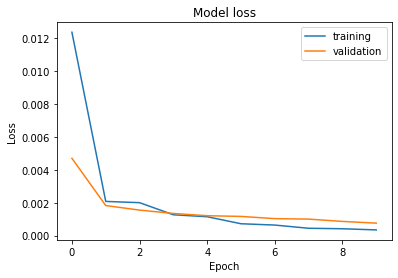

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [64]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
trainPredict_extended[:,predictCol] = trainPredict[:,0]
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,predictCol]

testPredict_extended = np.zeros((len(testPredict),num_of_features))
testPredict_extended[:,predictCol] = testPredict[:,0]
testPredict = scaler.inverse_transform(testPredict_extended)[:,predictCol] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,predictCol]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,predictCol]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,predictCol]=testY
testY = scaler.inverse_transform(testY_extended)[:,predictCol]

trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

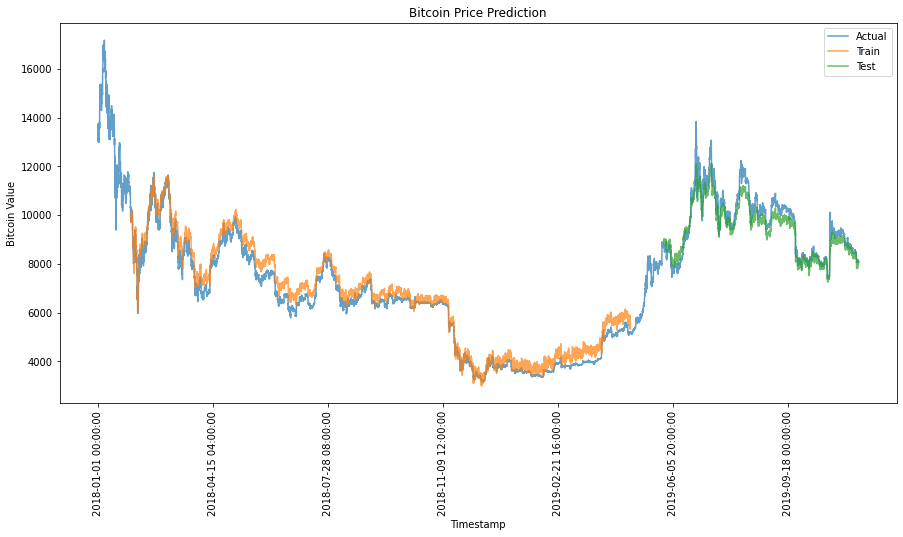

In [65]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, predictCol] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, predictCol] = testPredict

time_df = pd.DataFrame(df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,predictCol]
df1 = pd.DataFrame(trainPredictPlot[:,predictCol],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,predictCol],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('timestamp',inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [66]:
print('*' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))
print('*' * 50)

--------------------------------------------------
Experiment name: expr_4
--------------------------------------------------
look_back days: 30.0
lstm_layers: 42
epochs: 10
batch_size: 128
dataset features ['open_BTCUSDT', 'high_BTCUSDT', 'low_BTCUSDT', 'close_BTCUSDT', 'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD', 'volume_ETHUSD', 'reddit_flair', 'reddit_tb_polarity', 'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg']
--------------------------------------------------
Train Score: 394.56 RMSE
Test Score: 393.72 RMSE
--------------------------------------------------
Train Score: 347.40 MAE
Test Score: 328.53 MAE
--------------------------------------------------
Model summary:
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 42)                9576      
____________________________________________________________